# Out-Of-Distribution Data Detection

In this simple example we will explore some aspects of the behavior of Deep Networks on Out-Of-Distribution (OOD) samples. We will train a shallow CNN on CIFAR-10 and see how the network responds to **random** inputs. In our laboratory next week we will follow up on this with some deeper analysis and some exercises related to generating **targeted** adversarial samples.

In [1]:
# Standard imports.
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import FakeData, CIFAR10, CIFAR100
import torchvision.transforms as transforms

# Select best device.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

c:\Users\loreb\miniconda3\envs\DLA\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Datasets

We will use the CIFAR-10 dataset as a basis for our analysis. It's reasonably small and its easy to find OOD samples for it (it's much harder for, say, *ImageNet*).

In [3]:
# We will use CIFAR-10 as our in-distribution dataset.
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load the datasets and setup the DataLoaders.
batch_size = 32
ds_train = CIFAR10(root='../data', train=True, download=True, transform=transform)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=2)

ds_test = CIFAR10(root='../data', train=False, download=True, transform=transform)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=2)

# In case we want to pretty-print classifications.
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


This is probably a dataset you have never used... `FakeData` generates images using *Gaussian noise*. Setup the dataset for 32x32 RGB images, and a corresponding DataLoader.

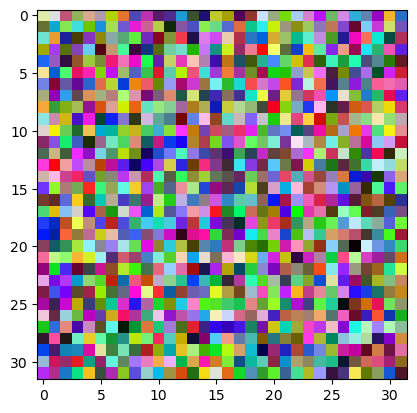

In [4]:
# Fake dataset.
ds_fake = FakeData(size=1000, image_size=(3, 32, 32), transform=transform)
dl_fake = torch.utils.data.DataLoader(ds_fake, batch_size=batch_size, shuffle=False, num_workers=2)

# Plot a fake image.
plt.imshow(FakeData(size=1, image_size=(3, 32, 32))[0][0])

### Our CNN

This is a simple and shallow CNN model with only two convolutional layers.

In [5]:
# A very simple CNN model.
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Training the base model

We train our CNN on CIFAR-10 for a minimal number of epochs. Note, I have also uploaded the already-trained model for those of you without a GPU.

In [9]:
# USE THIS CELL TO LOAD THE PRETRAINED MODEL.
model = CNN().to(device)
model.load_state_dict(torch.load('./cifar10_CNN.pth'))

<All keys matched successfully>

In [ ]:
# USE THIS CELL TO TRAIN MODEL FROM SCRATCH.
model = CNN().to(device)

# Train for only 50 epochs.
epochs = 50
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Main training loop.
for epoch in range(epochs):
    running_loss = 0.0
    # Iterate over all batches.
    for (i, (Xs, ys)) in enumerate(dl_train, 0):
        Xs = Xs.to(device)
        ys = ys.to(device)
        
        # Make a gradient step.
        optimizer.zero_grad()
        outputs = model(Xs)
        loss = criterion(outputs, ys)
        loss.backward()
        optimizer.step()
        
        # Track epoch loss.
        running_loss += loss.item()

    # Print average epoch loss.
    print(f'{epoch + 1} loss: {running_loss / len(dl_train):.3f}')

print('Finished Training')
torch.save(model.state_dict(), './cifar10_CNN.pth')

### Analyzing In Distribution (ID) and OOD behavior.

The simplest thing we could do, ideally, is just look at the logit response from the model. If the max logit is "too low", it *must* be an OOD sample. Let's try...

In [10]:
# Function to collect all logits from the model on entire dataset.
def collect_logits(model, dl):
    logits = []
    with torch.no_grad():
        for (Xs, _) in dl:
            logits.append(model(Xs.to(device)).cpu().numpy())
    return np.vstack(logits)

In [11]:
# Collect logits on CIFAR-10 test set (ID) and noise (very OOD).
logits_ID = collect_logits(model, dl_test)
logits_OOD = collect_logits(model, dl_fake)

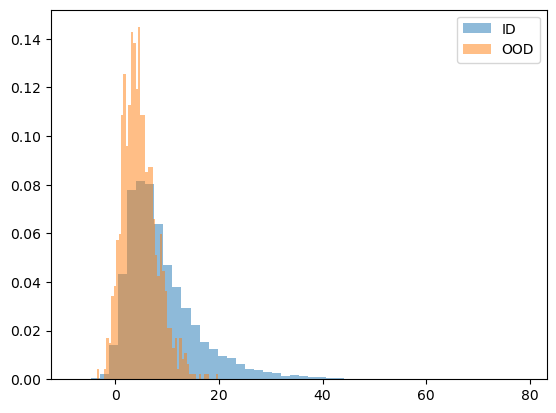

In [12]:
# Plot the *distribution* of max logit outputs.
_ = plt.hist(logits_ID.max(1), 50, density=True, alpha=0.5, label='ID')
_ = plt.hist(logits_OOD.max(1), 50, density=True, alpha=0.5, label='OOD')
plt.legend()

### To think about

Here are a few things to think and try out about before the next laboratory.

1. Is looking at the max logit the *best* we can do using *just* the CNN outputs? Is there maybe a better way to try to gauge model *confidence* from the logits?

2. Does the behavior of the network on OOD data get *better* or *worse* with more (or fewer) training epochs? 

2. Does the problem get worse if we test using *real* images as OOD samples? Find a subset of CIFAR-100 classes that are *distinct* from those in CIFAR-10 and test this theory.
